In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast


In [11]:
movies = pd.read_csv('/content/drive/MyDrive/movie_analytics/tmdb_5000_movies.csv', low_memory=False)
credits = pd.read_csv('/content/drive/MyDrive/movie_analytics/tmdb_5000_credits.csv')


In [12]:
# Convert numeric columns
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
movies['revenue'] = pd.to_numeric(movies['revenue'], errors='coerce')
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')


In [13]:
movies = movies.dropna(subset=['release_date', 'budget', 'revenue'])
movies = movies[movies['budget'] > 0]
movies = movies[movies['revenue'] > 0]


In [14]:
credits.rename(columns={'id': 'movie_id'}, inplace=True)
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
combined = pd.merge(movies, credits, left_on='id', right_on='movie_id')


In [15]:
combined['roi'] = (combined['revenue'] - combined['budget']) / combined['budget']


In [16]:
combined['release_year'] = combined['release_date'].dt.year


In [18]:
combined.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'crew', 'roi',
       'release_year'],
      dtype='object')

In [19]:
combined.rename(columns={'title_x': 'title'}, inplace=True)


In [22]:
combined[['title', 'budget', 'revenue', 'roi']].sort_values(by='roi', ascending=False).head(15)


,title,budget,revenue,roi
3078,Modern Times,1,8500000,8.499999e+06
2522,Nurse 3-D,10,10000000,9.999990e+05
3173,Paranormal Activity,15000,193355800,1.288939e+04
3175,Tarnation,218,1162014,5.329339e+03
3157,The Blair Witch Project,60000,248000000,4.132333e+03
3218,Eraserhead,10000,7000000,6.990000e+02
3225,Pink Flamingos,12000,6000000,4.990000e+02
3220,Super Size Me,65000,28575078,4.386166e+02
3217,The Gallows,100000,42664410,4.256441e+02
3161,Open Water,130000,54667954,4.195227e+02


In [23]:
# Remove entries with budget or revenue less than $1000
combined_clean = combined[(combined['budget'] > 1000) & (combined['revenue'] > 1000)]

# Also filter extreme ROI (e.g., ROI > 10000 is often unrealistic)
combined_clean = combined_clean[combined_clean['roi'] < 10000]


/tmp/ipython-input-25-1262877433.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_roi, x='roi', y='title', palette='magma')


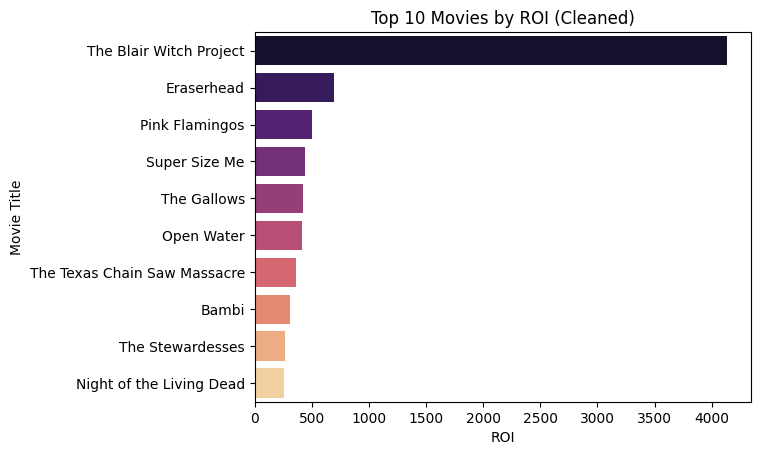

In [25]:
top_roi = combined_clean.sort_values(by='roi', ascending=False)[['title', 'roi']].head(10)

sns.barplot(data=top_roi, x='roi', y='title', palette='magma')
plt.title("Top 10 Movies by ROI (Cleaned)")
plt.xlabel("ROI")
plt.ylabel("Movie Title")
plt.show()


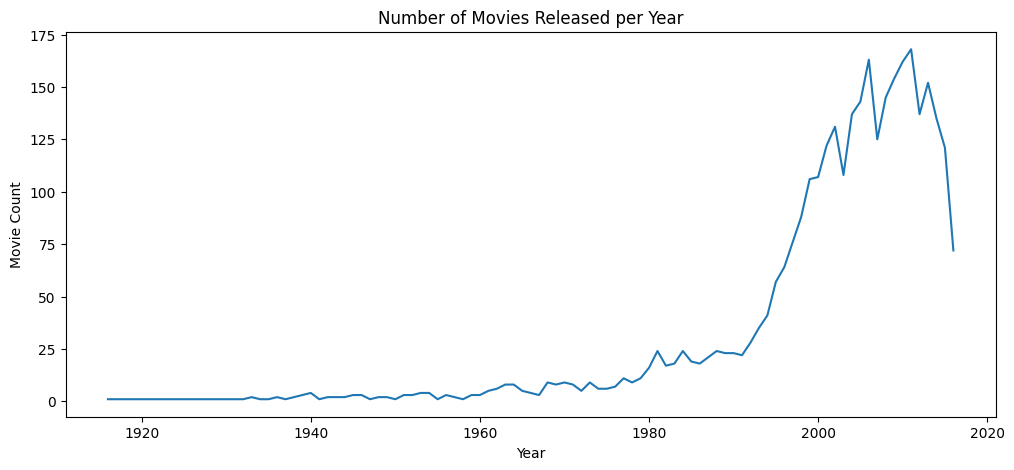

In [26]:
movies_per_year = combined['release_year'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values)
plt.title("Number of Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Movie Count")
plt.show()


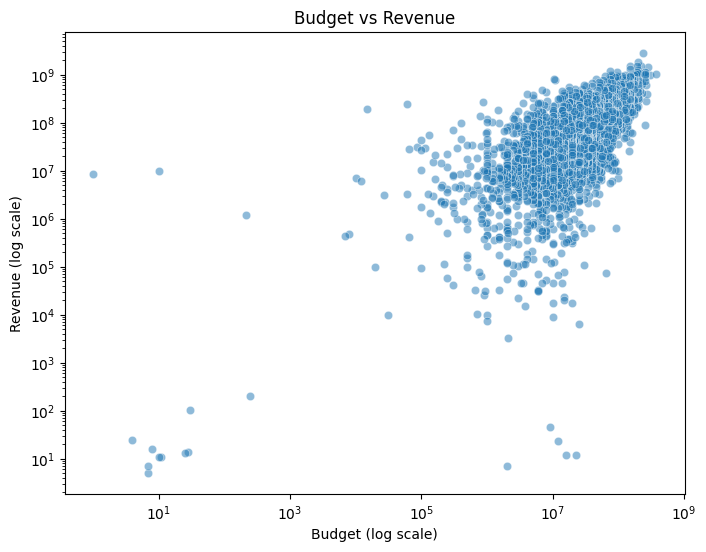

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined, x='budget', y='revenue', alpha=0.5)
plt.title("Budget vs Revenue")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Budget (log scale)")
plt.ylabel("Revenue (log scale)")
plt.show()


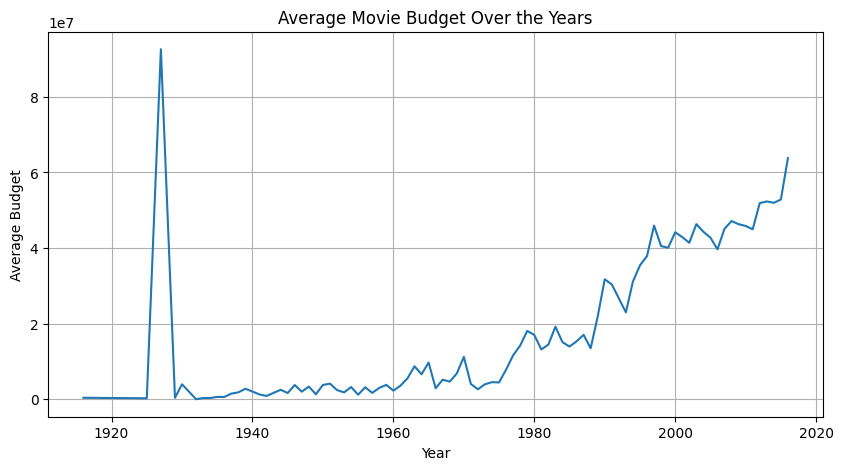

In [28]:
yearly_budget = combined.groupby('release_year')['budget'].mean()

yearly_budget.plot(figsize=(10,5))
plt.title("Average Movie Budget Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Budget")
plt.grid(True)
plt.show()


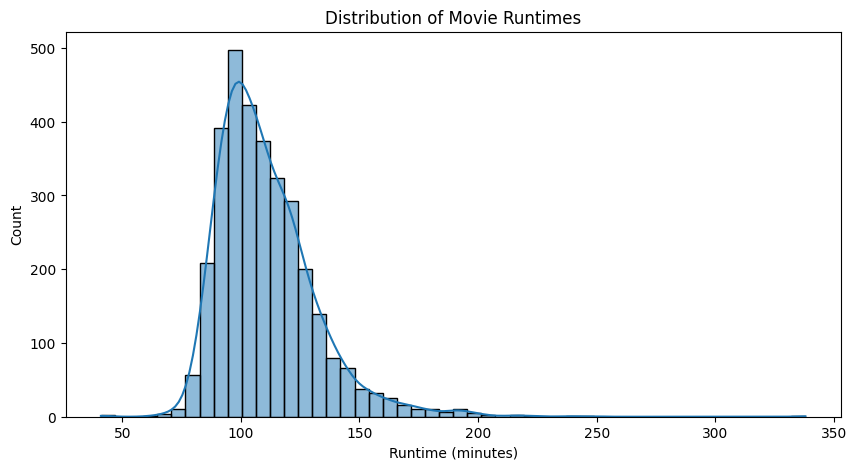

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(combined['runtime'].dropna(), bins=50, kde=True)
plt.title("Distribution of Movie Runtimes")
plt.xlabel("Runtime (minutes)")
plt.show()


/tmp/ipython-input-31-1690310630.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Movie Count', y='Country', data=top_countries, palette='viridis')


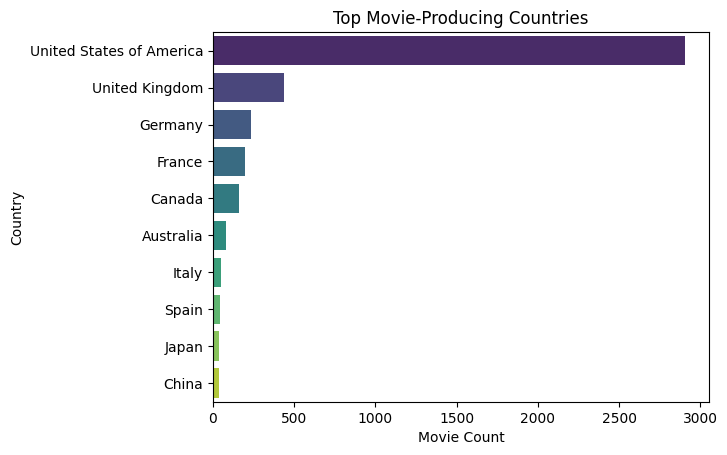

In [31]:
def get_country(x):
    try:
        return [i['name'] for i in ast.literal_eval(x)]
    except:
        return []

combined['countries'] = combined['production_countries'].apply(get_country)

from collections import Counter
country_count = Counter()
combined['countries'].apply(country_count.update)

top_countries = pd.DataFrame(country_count.most_common(10), columns=['Country', 'Movie Count'])

sns.barplot(x='Movie Count', y='Country', data=top_countries, palette='viridis')
plt.title("Top Movie-Producing Countries")
plt.show()


/tmp/ipython-input-38-2068333756.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_actors, x='Count', y='Actor', palette='coolwarm')


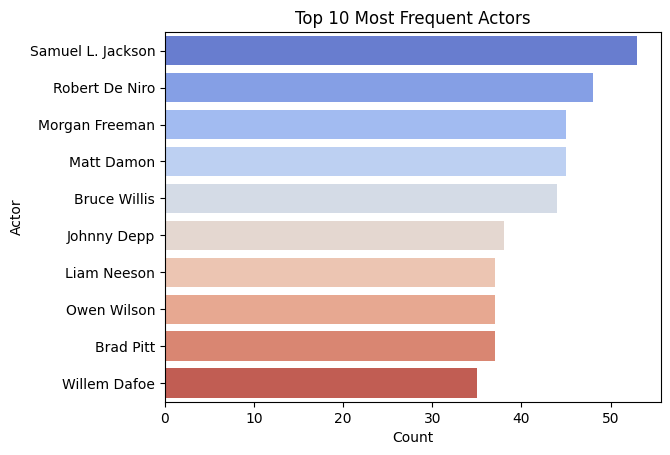

In [38]:
def get_actors(x):
    try:
        return [i['name'] for i in ast.literal_eval(x)]
    except:
        return []

combined['cast_list'] = combined['cast'].apply(get_actors)

actor_counter = Counter()
combined['cast_list'].apply(actor_counter.update)

top_actors = pd.DataFrame(actor_counter.most_common(10), columns=['Actor', 'Count'])

sns.barplot(data=top_actors, x='Count', y='Actor', palette='coolwarm')
plt.title("Top 10 Most Frequent Actors")
plt.show()


In [40]:
def extract_names(obj):
    try:
        return [d['name'] for d in ast.literal_eval(obj)]
    except:
        return []

combined['genres_list'] = combined['genres'].apply(extract_names)


/tmp/ipython-input-42-3596075487.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')


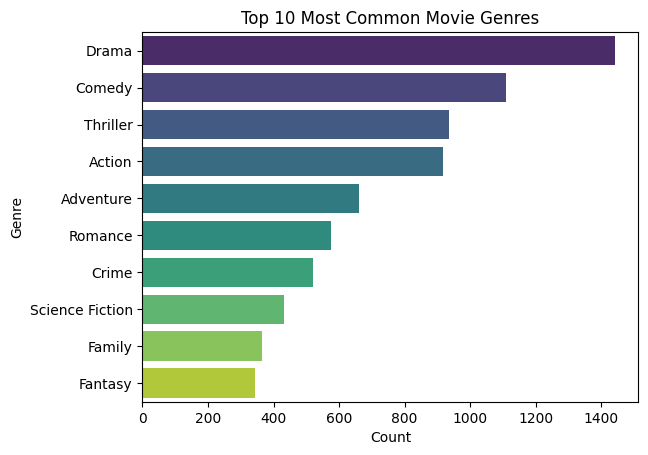

In [42]:
from collections import Counter

genre_counter = Counter()
combined['genres_list'].apply(genre_counter.update)

top_genres = pd.DataFrame(genre_counter.most_common(10), columns=['Genre', 'Count'])

sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')
plt.title("Top 10 Most Common Movie Genres")
plt.show()
